## Maximum vertial wind map

Use data provided by the Unified Model's .pe0 file to geographically locate the site of the largest vertial winds within a model domain. Animate this data as the model progresses. Useful for diagnosing model instabilities.

In [1]:
import xarray as xr
import datetime
import cartopy.crs as ccrs
from matplotlib import pyplot as plt, animation

In [2]:
ts1=30
starttime=datetime.datetime(year=2022,month=2,day=21,hour=18)
td1=datetime.timedelta(seconds=ts1)

ts2=75
td2=datetime.timedelta(seconds=ts2)

tdg=datetime.timedelta(seconds=15)

In [3]:
ds=xr.open_dataset(f"/g/data/hh5/tmp/WACI-Hackathon-2023/AUS2200/data/surf/orog_1hr_{(starttime + datetime.timedelta(hours=7)).strftime('%Y%m%d')}_20220307.nc")

In [4]:
ds

<xarray.Dataset>
Dimensions:    (latitude: 2120, longitude: 2600, time: 336)
Coordinates:
  * latitude   (latitude) float32 -48.79 -48.77 -48.75 ... -6.871 -6.852 -6.832
  * longitude  (longitude) float32 107.5 107.5 107.6 107.6 ... 158.9 159.0 159.0
  * time       (time) datetime64[ns] 2022-02-22T00:00:30 ... 2022-03-08
Data variables:
    orog       (time, latitude, longitude) float32 ...
Attributes: (12/25)
    Conventions:          CF-1.6, ACDD-1.3
    title:                AUS2200 UM amip simulation over Australian region f...
    summary:              A limited area model study of the entire Australian...
    source:               UM v12.2 ECMWF ERA5 forecast fields used as forcings
    license:              http://creativecommons.org/licenses/by/4.0/
    product_version:      0.1
    ...                   ...
    geospatial_lon_min:   107.5101
    geospatial_lon_max:   0.0198
    contributor_name:     Sam Green, Paola Petrelli
    contributor_email:    sam.green@unsw.edu.au, paola.petrelli@utas.edu.au
    contributor_url:      https://orcid.org/0000-0003-1129-4676, https://orci...
    contributor_role:     post-processing, post-processing

In [5]:
x_min=min(ds.longitude)
x_max=max(ds.longitude)
y_min=min(ds.latitude)
y_max=max(ds.latitude)
ex=(x_min,x_max,y_min,y_max)
x_minf=x_min.data.item()
x_maxf=x_max.data.item()
y_minf=y_min.data.item()
y_maxf=y_max.data.item()

In [6]:
x_max

<xarray.DataArray 'longitude' ()>
array(158.9802, dtype=float32)
Coordinates:
    longitude  float32 159.0
Attributes:
    standard_name:  longitude
    units:          degrees

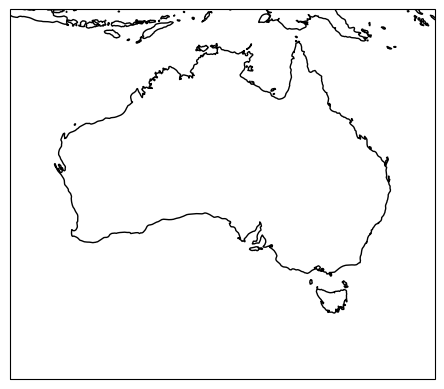

In [7]:
ax=plt.axes(projection=ccrs.PlateCarree())
ax.coastlines('50m',linewidth=1)
ax.set_extent(ex)

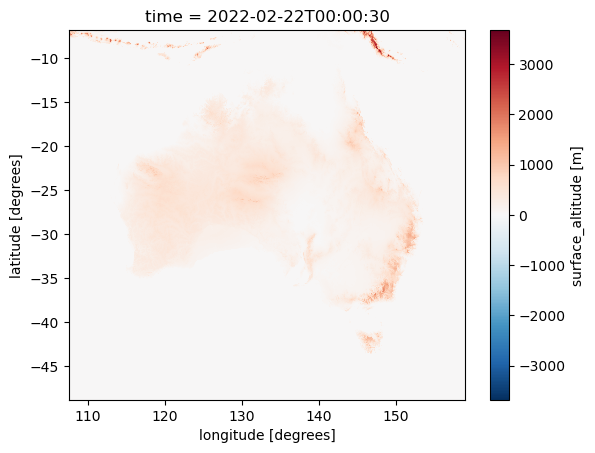

In [8]:
ds.orog[0].plot()

In [9]:
prefix=f'/scratch/w40/dr4292/aus2200-instability-analysis/{ts1}sec/'
suffix='Z/aus2200_d0198_RA3_um_fcst_000/pe_output/umnsa.fort6.pe0000'
lines30=[]
for f in ( f'{prefix}20220221T1800{suffix}', f'{prefix}20220222T0000{suffix}' ):
    with open(f,'r') as f:
        lines30.extend([ i.strip() for i in f.readlines() ])
prefix=f'/scratch/w40/dr4292/aus2200-instability-analysis/{ts2}sec/'
lines75=[]
for f in ( f'{prefix}20220221T1800{suffix}', f'{prefix}20220222T0000{suffix}' ):
    with open(f,'r') as f:
        lines75.extend([ i.strip() for i in f.readlines() ])

In [10]:
winddat30_lines=[]
countdown=-1
for l in lines30:
    countdown=countdown-1
    if l.startswith('Maximum vertical velocity'): countdown=2
    if countdown==0:
        winddat30_lines.append(l)
        
winddat75_lines=[]
countdown=-1
for l in lines75:
    countdown=countdown-1
    if l.startswith('Maximum vertical velocity'): countdown=2
    if countdown==0:
        winddat75_lines.append(l)

In [11]:
winddat30=[ ( starttime+it*td1,float(i.split()[0]),int(i.split()[1]),x_minf+(float(i.split()[3].strip('%'))/100.0)*(x_maxf-x_minf),y_minf+(float(i.split()[5].strip('%'))/100.0)*(y_maxf-y_minf))  for it,i in enumerate(winddat30_lines) ]
winddat75=[ ( starttime+it*td2,float(i.split()[0]),int(i.split()[1]),x_minf+(float(i.split()[3].strip('%'))/100.0)*(x_maxf-x_minf),y_minf+(float(i.split()[5].strip('%'))/100.0)*(y_maxf-y_minf))  for it,i in enumerate(winddat75_lines) ]

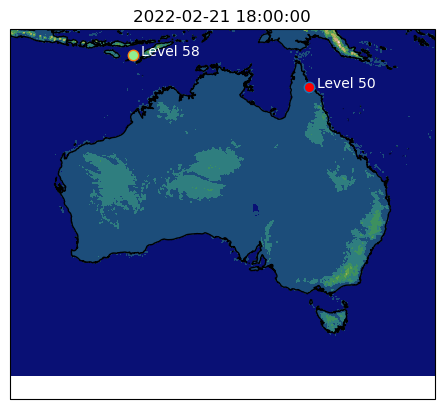

In [12]:
time=starttime
i30=0
i75=0
while True:
    _,_,lev30,x30,y30=winddat30[i30]
    _,_,lev75,x75,y75=winddat75[i75]
    ax=plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines('10m',linewidth=1)
    ax.set_extent(ex)
    ax.contourf(ds.longitude,ds.latitude,ds.orog[0],cmap='gist_earth')
    plt.title(time)
    a=plt.plot(x30,y30,marker="o",markersize=7.5,markerfacecolor='red')
    b=plt.plot(x75,y75,marker="o",markersize=7.5,markerfacecolor='lightgreen')
    c=plt.text(x30+1,y30,f"Level {lev30}",color='white')
    d=plt.text(x75+1,y75,f"Level {lev75}",color='white')
    plt.show()
    time=time+tdg
    if winddat30[i30+1][0] == time:
        i30 = i30+1
    if winddat75[i75+1][0] == time:
        i75 = i75+1
    break

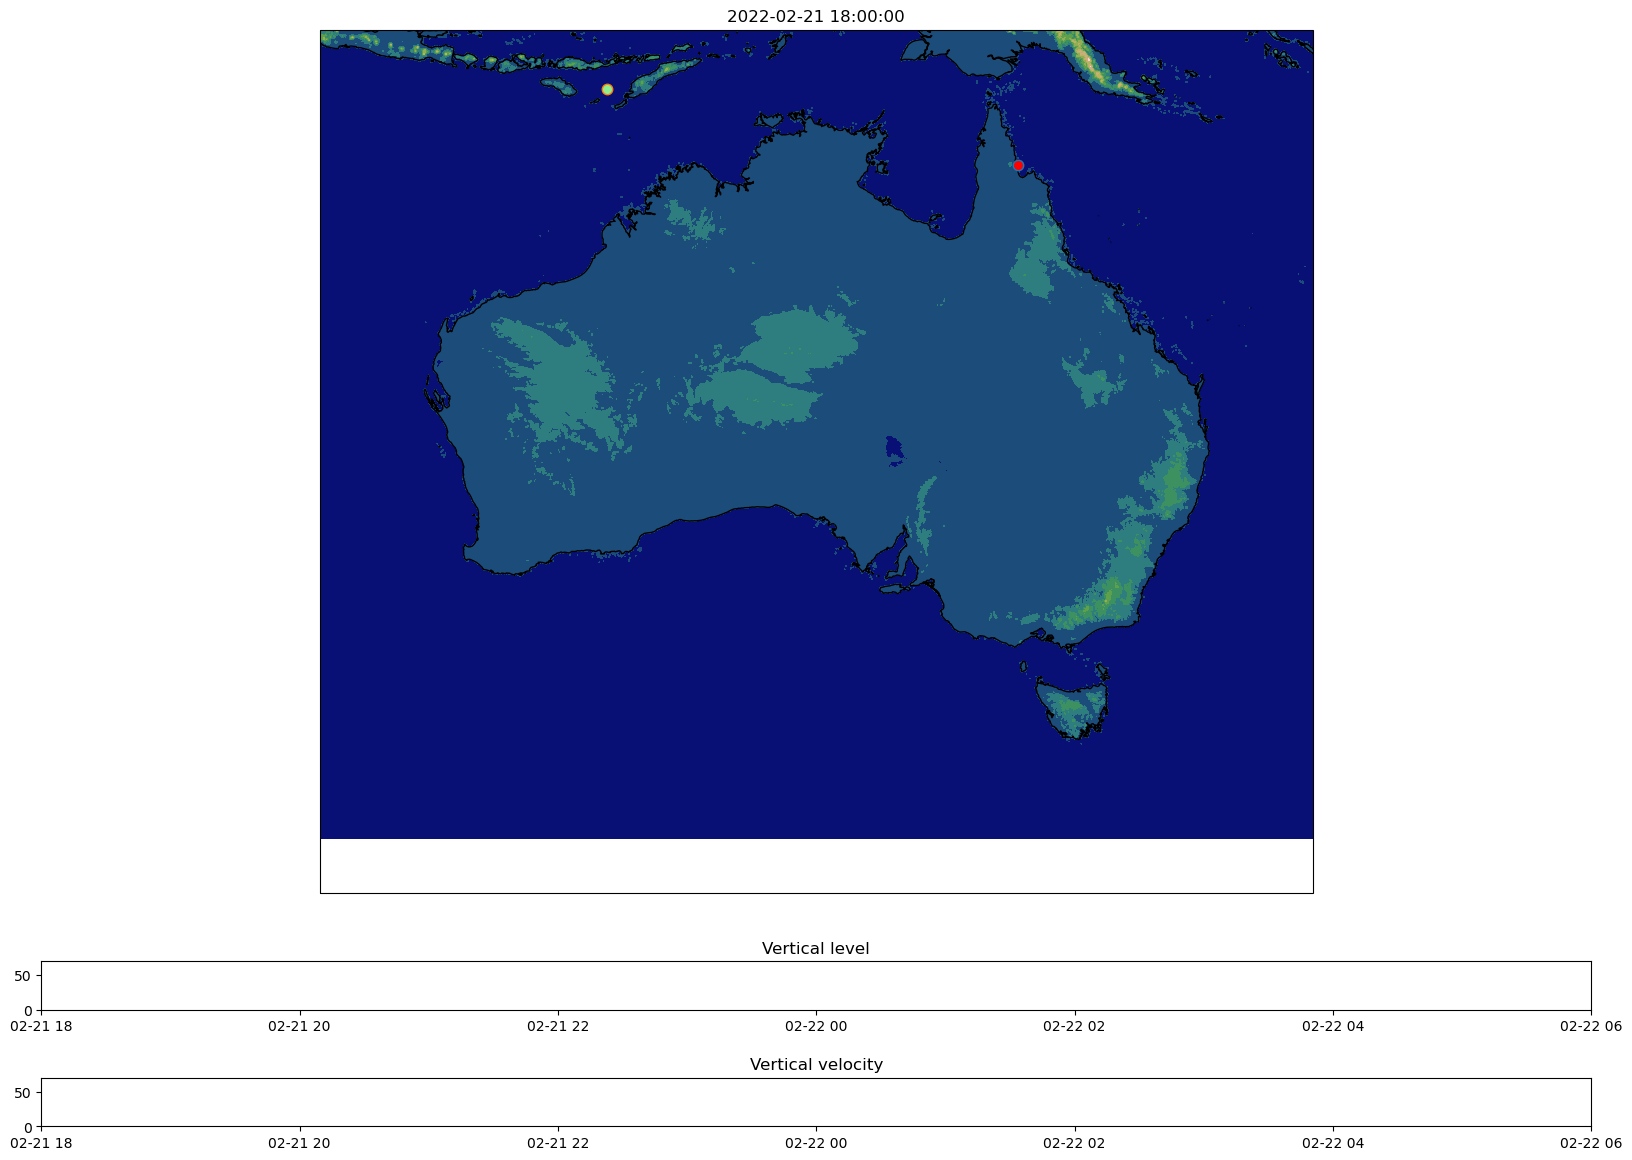

In [13]:
fig = plt.figure(layout=None,figsize=(20,15))
gs = fig.add_gridspec(ncols=1,nrows=20)
ax0 = fig.add_subplot(gs[:-5],projection=ccrs.PlateCarree())

#fig,axs = plt.subplots(nrows=3,figsize=(13, 10.6),gridspec_kw={'height_ratios': [4, 1, 1]},subplot_kw={'projection':ccrs.PlateCarree()})
#ax = plt.axes(projection=ccrs.PlateCarree())
ax0.coastlines('10m',linewidth=1)
ax0.set_extent(ex)
ax0.contourf(ds.longitude,ds.latitude,ds.orog[0],cmap='gist_earth')
ax0.set_title(starttime)
_,vel30,lev30,x30,y30=winddat30[0]
a = ax0.plot(x30,y30,marker="o",markersize=7.5,markerfacecolor='red')
#b = ax[0].text(x30+1,y30,f"Level {lev30}")
_,vel75,lev75,x75,y75=winddat75[0]
b = ax0.plot(x75,y75,marker="o",markersize=7.5,markerfacecolor='lightgreen')
#d = ax.text(x75+1,y75,f"Level {lev75}")

ax1 = fig.add_subplot(gs[-4])
line1, = ax1.step([], [], color='red')
line2, = ax1.step([], [], color='lightgreen')
ax1.set_ylim((0,70))
ax1.set_xlim((starttime,starttime+2880*tdg))
ax1.set_title("Vertical level")
times=[starttime,]
levs30=[lev30,]
levs75=[lev75,]
line1.set_data(times,levs30)
line2.set_data(times,levs75)

ax2 = fig.add_subplot(gs[-2])
line3, = ax2.step([],[], color='red')
line4, = ax2.step([],[], color='lightgreen')
ax2.set_title("Vertical velocity")
ax2.set_ylim((0,70))
ax2.set_xlim((starttime,starttime+2880*tdg))
vels30=[vel30,]
vels75=[vel75,]
line3.set_data(times,vels30)
line4.set_data(times,vels75)

In [14]:
def animate(frame):
    i30 = frame//2
    i75 = frame//5
    ax0.set_title(starttime + frame * tdg)
    times.append(starttime + frame * tdg)
    try:
        _,vel30,lev30,x30,y30=winddat30[i30]
        a[0].set_data((x30,y30))
        levs30.append(lev30)
        vels30.append(vel30)
        line1.set_data(times,levs30)
        line3.set_data(times,vels30)
    except:
        pass
    
    try:
        _,vel75,lev75,x75,y75=winddat75[i75]
        b[0].set_data((x75,y75))#,marker="o",markersize=7.5,markerfacecolor='blue')
        levs75.append(lev75)
        vels75.append(vel75)
        line2.set_data(times,levs75)
        line4.set_data(times,vels75)
    except:
        b[0].set_data((0,0))
    if frame%100 == 0:
        print(f"{frame} {i30} {i75} {x30} {y30}")

In [15]:
ani = animation.FuncAnimation(
    fig,             # figure
    animate,         # name of the function above
    frames=2880,       # Could also be iterable or list
    interval=33     # ms between frames
)

In [16]:
ani.save(f"/home/563/dr4292/aus2200_instability_analysis/multiplot.mp4")

0 0 0 143.69651544952393 -13.838483894348144
0 0 0 143.69651544952393 -13.838483894348144
100 50 20 122.49491410064698 -10.188294525146482
200 100 40 122.28907331085205 -10.146338325500494
300 150 60 122.44345390319825 -10.398075523376463
400 200 80 122.34053350830078 -10.314163124084473
500 250 100 122.44345390319825 -10.69176892089844
600 300 120 126.30296871185303 -10.146338325500494
700 350 140 122.80367528533935 -11.0693747177124
800 400 160 122.75221508789063 -11.0693747177124
900 450 180 121.41424995422364 -10.272206924438478
1000 500 200 121.25986936187743 -10.356119323730475
1100 550 220 122.5463742980957 -11.027418518066405
1200 600 240 122.44345390319825 -11.027418518066405
1300 650 260 122.34053350830078 -11.0693747177124
1400 700 280 123.00951607513427 -11.111330917358394
1500 750 300 124.65624239349364 -11.446980514526366
1600 800 320 154.9662986907959 -15.390863281250006
1700 850 340 127.84677463531494 -12.537841705322265
1800 900 360 143.59359505462646 -28.1035917739868